## Need to set up a notebook dependencies check section

In [30]:
try:
    setup_gcgs_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++
[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.
+++++++++++++++++++++++++++++++


## Import Libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import boto3.session
import sagemaker

gcgs_sess = boto3.session.Session() # Create our own session
gcgs_sess1 = boto3.Session() # MZ EXPERIMENT
gcgs_region = gcgs_sess.region_name
gcgs_sm_sess = sagemaker.Session(default_bucket="my-508-projects2") # Assigned variable with sagemaker resources available
# ASSIGNED NEW DEFAULT BUCKET: "my-508-projects2"
gcgs_bucket = gcgs_sm_sess.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=gcgs_region)
s31 = gcgs_sess.client(service_name="s3", region_name=gcgs_region) # MZ EXPERIMENT

print(gcgs_sess)
print(gcgs_sess1)
print(gcgs_region)
print(gcgs_sm_sess)
print(gcgs_bucket)
print(s3)
s31

Session(region_name='us-east-1')
Session(region_name='us-east-1')
us-east-1
my-508-projects2


## Model code

In [32]:
!aws s3 cp 's3://my-508-projects2/eng_mlcsv/eng_mlcsv2.csv' ./data_model/

download: s3://my-508-projects2/eng_mlcsv/eng_mlcsv2.csv to data_model/eng_mlcsv2.csv


In [33]:
import csv
ml = pd.read_csv(
    r"./data_model/eng_mlcsv2.csv",
    engine = 'python',
    dtype={'NDC5_4':str}  # Must encode NDC with leading 0s as 'str'
)
ml.shape

(93869, 14)

In [34]:
ml = ml.dropna()
ml.shape

(91497, 14)

In [35]:
ml.dtypes

ptnt_pay_amt           int64
total_cost             int64
cost_per_day         float64
isgeneric            float64
TOT_RX_CST_AMT         int64
year                   int64
bene_sex_ident_cd      int64
bene_race_cd           int64
age_code               int64
esrd                   int64
region_code            int64
cont_enroll            int64
ccnum                  int64
high_ben               int64
dtype: object

In [36]:
#TARGET needs to be first col for XGBoost
ml = ml[['isgeneric', 'ptnt_pay_amt', 'total_cost', 'cost_per_day', 'TOT_RX_CST_AMT',
         'year', 'bene_sex_ident_cd', 'bene_race_cd', 'age_code', 'esrd', 'region_code',
         'cont_enroll', 'ccnum', 'high_ben']]
ml.head(5)

,isgeneric,ptnt_pay_amt,total_cost,cost_per_day,TOT_RX_CST_AMT,year,bene_sex_ident_cd,bene_race_cd,age_code,esrd,region_code,cont_enroll,ccnum,high_ben
0,1.0,0,10,1.0,10,2010,2,1,1,0,6,0,0,0
1,1.0,0,10,1.0,10,2009,2,1,1,0,6,0,0,1
2,1.0,0,10,1.0,10,2008,2,1,1,1,6,0,1,1
3,1.0,0,0,0.0,0,2009,1,3,3,0,3,1,0,1
4,1.0,0,0,0.0,0,2010,1,3,3,0,3,1,0,1


Text(0, 0.5, 'Generic Count')

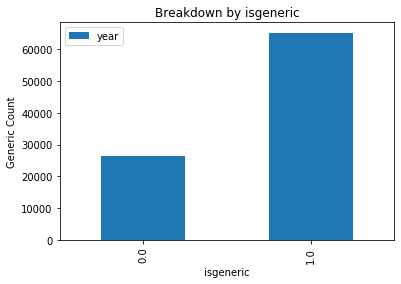

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline
#%config InlineBackend.figure_format='retina'

ml[['isgeneric','year']].groupby('isgeneric').count().plot(kind="bar", title="Breakdown by isgeneric")
plt.xlabel("isgeneric")
plt.ylabel("Generic Count")

In [38]:
# Balance the dataset down to the minority class
ml_grouped_by = ml.groupby(["isgeneric"]) 
ml_balanced = ml_grouped_by.apply(lambda x: x.sample(ml_grouped_by.size().min()).reset_index(drop=True))

ml_balanced = ml_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(ml_balanced.shape))

Shape of balanced dataframe (52576, 14)


In [39]:
ml_balanced.head(5)

,isgeneric,ptnt_pay_amt,total_cost,cost_per_day,TOT_RX_CST_AMT,year,bene_sex_ident_cd,bene_race_cd,age_code,esrd,region_code,cont_enroll,ccnum,high_ben
0,0.0,0,50,1.666667,50,2008,1,1,3,0,6,1,0,1
1,0.0,20,180,6.000000,160,2010,2,1,2,1,2,1,0,1
2,0.0,10,80,2.666667,70,2010,2,1,2,0,1,1,0,1
3,0.0,0,260,2.888889,260,2009,2,1,4,0,4,1,0,0
4,0.0,0,20,0.666667,20,2009,1,1,1,0,2,0,0,1


In [40]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
ml_train, ml_holdout = train_test_split(ml_balanced, test_size=0.30, stratify=ml_balanced["isgeneric"])

# Split holdout data into 50% validation and 50% test
ml_validation, ml_test = train_test_split(ml_holdout, test_size=0.50, stratify=ml_holdout["isgeneric"])

print(ml_train.shape)
print(ml_validation.shape)
ml_test.shape

(36803, 14)
(7886, 14)


(7887, 14)

In [41]:
filepath1 = "./data_model/ml_train.csv"
filepath2 = "./data_model/ml_validation.csv"
ml_train.to_csv(filepath1, index=False, header=True)
ml_train.to_csv(filepath2, index=False, header=True)

# COPY CSVs TO S3

#import time

# The timestamp is for creating a fresh folder.  Disabled here so S3 will write over with newly engineered files.
#timestamp = int(time.time())
eng_df1_s3_uri = gcgs_sm_sess.upload_data(bucket=gcgs_bucket, key_prefix="eng_model", path=filepath1)
eng_df2_s3_uri = gcgs_sm_sess.upload_data(bucket=gcgs_bucket, key_prefix="eng_model", path=filepath2)
#eng_df_s3_uri = gcgs_sm_sess.upload_data(bucket=gcgs_bucket, key_prefix="eng_df-{}".format(timestamp), path=filepath)
print(eng_df1_s3_uri)
print(eng_df2_s3_uri)

# LIST DATA IN THE NEW S3 LOCATION

!aws s3 ls $eng_df1_s3_uri
!aws s3 ls $eng_df2_s3_uri

s3://my-508-projects2/eng_model/ml_train.csv
s3://my-508-projects2/eng_model/ml_validation.csv
2022-04-03 22:22:13    1564795 ml_train.csv
2022-04-03 22:22:13    1564795 ml_validation.csv


## Bring back the csv from S3

## XGBoost Code that ran in my Personal AWS Account

In [42]:
#import sagemaker
#import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input, Session
            
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:squarederror",
        "num_round":"50"}

# set an output path where the trained model will be saved
prefix = 'eng_model'
output_path = 's3://{}/{}/{}/output'.format(gcgs_bucket, prefix, 'generics-xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.large', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
train_input = s3_input("s3://{}/{}/{}".format(gcgs_bucket, prefix, 'ml_train.csv'), content_type='csv')
validation_input = s3_input("s3://{}/{}/{}".format(gcgs_bucket, prefix, 'ml_validation.csv'), content_type='csv')

# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-04-03 22:22:14 Starting - Starting the training job...
2022-04-03 22:22:34 Starting - Preparing the instances for trainingProfilerReport-1649024534: InProgress
.........
2022-04-03 22:23:57 Downloading - Downloading input data......
2022-04-03 22:24:57 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:25:53] 36804x13 matrix with 478452 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV input is ','
[22

## Run the XGBoost algorithm

In [43]:
# code copied from:  https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html